In [1]:
!pip install tensorflow==2.10.0
!pip install keras==2.10.0
!pip install h5py==3.10.0
!pip install efficientnet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!unzip /content/drive/MyDrive/smart_contract_classification/generated_image_data.zip -d /content/drive/MyDrive/smart_contract_classification/Data

In [4]:
import numpy as np
import pickle
import os
from tqdm import tqdm
import cv2
import pandas as pd
import seaborn as sns
from os import listdir
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import layers
from sklearn.metrics import classification_report,confusion_matrix
import efficientnet.keras as effnet
from tensorflow.keras.applications.xception import Xception

In [5]:
from tensorflow.keras import backend as K
K.clear_session()
import tensorflow
tensorflow.__version__

'2.10.0'

In [6]:
image_size=128
default_image_size = tuple((128, 128))
directory_root = '/content/drive/MyDrive/smart_contract_classification/Data'
BATCHZ_SIZE=64

In [7]:
def image_array(dir):
    try:
        img = cv2.imread(dir)
        if img is not None :
            img = cv2.resize(img, default_image_size)
            return img_to_array(img)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [8]:
imagedata, labeldata = [], []

try:
  for imagename in os.listdir(directory_root):
    if imagename.split('_')[0] != 'ether frozen (EF)':
      image_dir = f"{directory_root}/{imagename}"
      if image_dir.endswith(".png") == True or image_dir.endswith(".PNG") == True:
        print(image_dir)
        imagedata.append(image_array(image_dir))
        labeldata.append(imagename.split('_')[0])
  print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

/content/drive/MyDrive/smart_contract_classification/Data/integer overflow (OF)_1010.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/ether strict equality (SE)_547.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/ether strict equality (SE)_542.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/ether strict equality (SE)_541.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/integer overflow (OF)_1018.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/ether strict equality (SE)_537.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/ether strict equality (SE)_546.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/ether strict equality (SE)_526.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/integer overflow (OF)_1126.sol.png
/content/drive/MyDrive/smart_contract_classification/Data/integer overflow (OF)_1066.sol.png
/content/drive/MyDrive/smart_contract_classifi

In [9]:
X = imagedata
Y = labeldata

In [10]:
X = np.array(X)

In [11]:
X, Y = shuffle(X, Y)
print(X.shape)

(2017, 128, 128, 3)


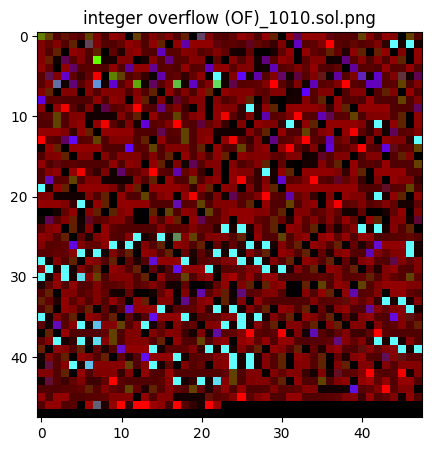

In [12]:

#Data Visualization
import matplotlib.image as mpimg
plt.figure(figsize = (5, 5))
image_count = 1
for imagename in os.listdir(directory_root)[:1]:
    image_dir = f"{directory_root}/{imagename}"
    image = mpimg.imread(image_dir)
    plt.imshow(image)
    plt.title(imagename)


<Axes: ylabel='count'>

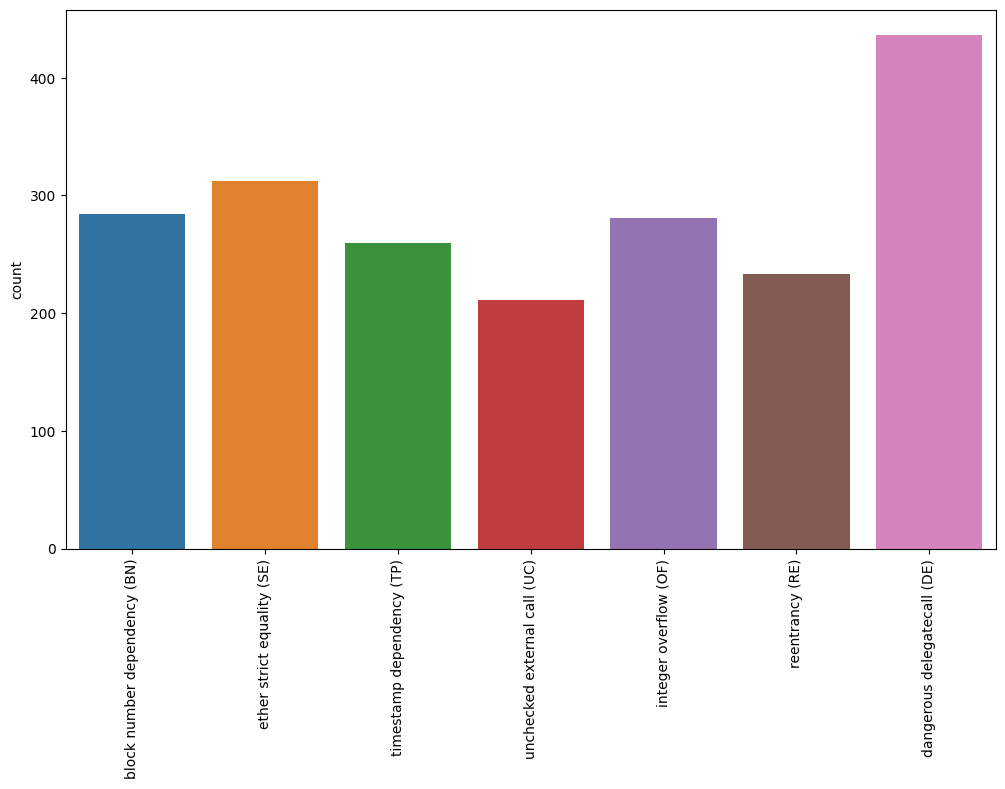

In [13]:
#count plot
plt.figure(figsize = (12, 7))
plt.xticks(rotation=90)
sns.countplot(x=Y)

In [14]:
#data balancing using smote
X = X.reshape(-1, image_size * image_size * 3)
X.shape
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
X = X.reshape(-1,image_size,image_size,3)


<Axes: ylabel='count'>

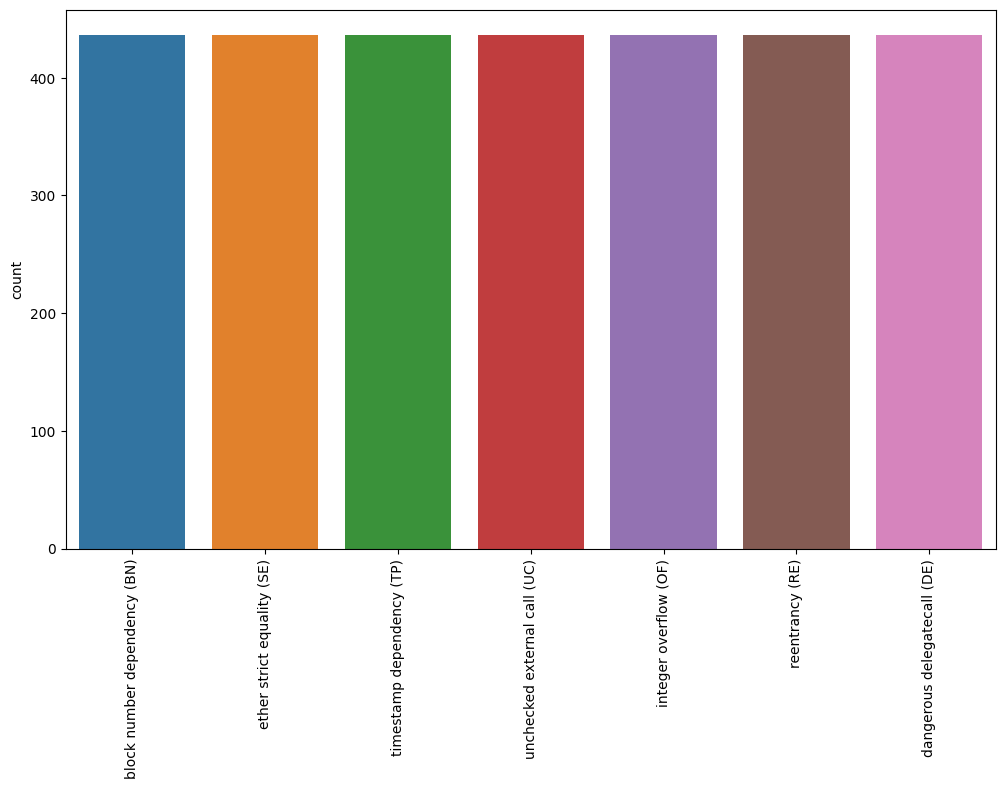

In [15]:
#count plot
plt.figure(figsize = (12, 7))
plt.xticks(rotation=90)
sns.countplot(x=Y)

In [16]:
class_labels = LabelBinarizer()
Y = class_labels.fit_transform(Y)
pickle.dump(class_labels,open('/content/drive/MyDrive/smart_contract_classification/label_transform.pkl', 'wb'))
n_classes = len(class_labels.classes_)

In [17]:
cls = len(class_labels.classes_)
print(class_labels.classes_)

['block number dependency (BN)' 'dangerous delegatecall (DE)'
 'ether strict equality (SE)' 'integer overflow (OF)' 'reentrancy (RE)'
 'timestamp dependency (TP)' 'unchecked external call (UC)']


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

In [19]:
X_train.shape

(2746, 128, 128, 3)

#CNN

In [ ]:
#CNN
depth=3
model = Sequential()
inputShape = (image_size, image_size, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, image_size, image_size)
    chanDim = 1
model.add(Conv2D(32, (2, 2), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 42, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        1

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train,batch_size=BATCHZ_SIZE,validation_data=(X_test, y_test),epochs=10, verbose=1)

Epoch 1/10
43/43 [==============================] - 13s 68ms/step - loss: 2.2539 - accuracy: 0.2724 - val_loss: 2.3691 - val_accuracy: 0.1536
Epoch 2/10
43/43 [==============================] - 2s 43ms/step - loss: 1.8575 - accuracy: 0.3773 - val_loss: 1.7974 - val_accuracy: 0.2941
Epoch 3/10
43/43 [==============================] - 2s 44ms/step - loss: 1.6804 - accuracy: 0.4370 - val_loss: 1.4789 - val_accuracy: 0.4608
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 1.5572 - accuracy: 0.4629 - val_loss: 1.2570 - val_accuracy: 0.5654
Epoch 5/10
43/43 [==============================] - 2s 39ms/step - loss: 1.4052 - accuracy: 0.5095 - val_loss: 1.1334 - val_accuracy: 0.6013
Epoch 6/10
43/43 [==============================] - 2s 40ms/step - loss: 1.3636 - accuracy: 0.5153 - val_loss: 1.0482 - val_accuracy: 0.6275
Epoch 7/10
43/43 [==============================] - 2s 40ms/step - loss: 1.2814 - accuracy: 0.5459 - val_loss: 0.9645 - val_accuracy: 0.6536
Epoch 8/10
4

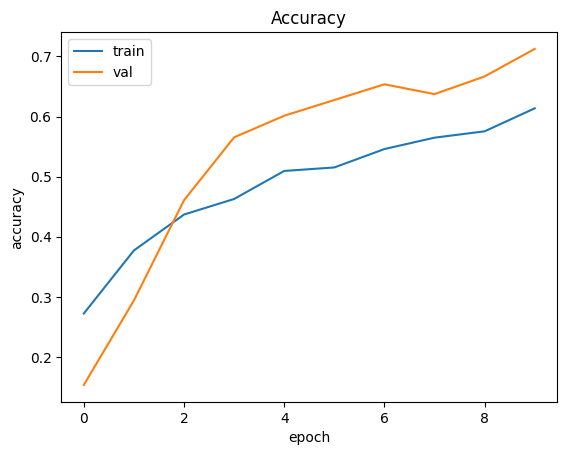

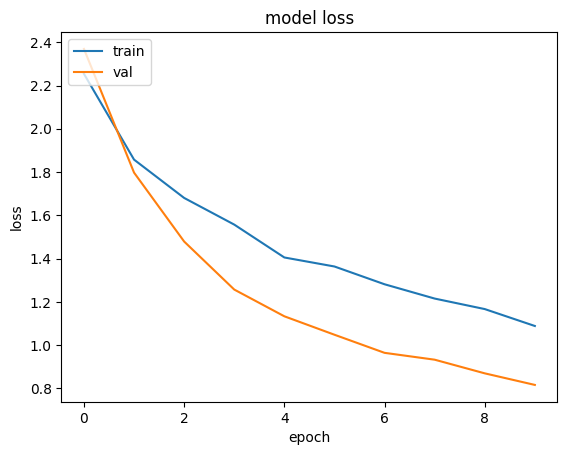

In [ ]:
#accuracy and loss plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 1s 23ms/step


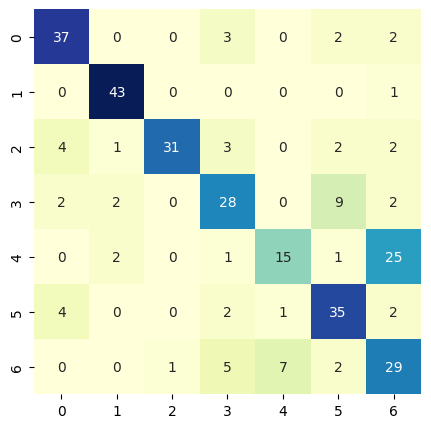

In [ ]:
cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d");

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81        44
           1       0.90      0.98      0.93        44
           2       0.97      0.72      0.83        43
           3       0.67      0.65      0.66        43
           4       0.65      0.34      0.45        44
           5       0.69      0.80      0.74        44
           6       0.46      0.66      0.54        44

    accuracy                           0.71       306
   macro avg       0.73      0.71      0.71       306
weighted avg       0.73      0.71      0.71       306



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(cls):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.961832,0.840909
1,1,0.980916,0.977273
2,2,0.996198,0.720930
3,3,0.946768,0.651163
4,4,0.969466,0.340909
5,5,0.938931,0.795455
6,6,0.870229,0.659091


#Xception

In [20]:
xception = Xception(input_shape=(image_size,image_size,3), weights='imagenet', include_top=False)

xception.trainable = True

model = Sequential([xception,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation='sigmoid')
])


In [21]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(),metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train, batch_size=BATCHZ_SIZE, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
43/43 [==============================] - 32s 424ms/step - loss: 1.6953 - accuracy: 0.3423 - val_loss: 1.9375 - val_accuracy: 0.1830
Epoch 2/10
43/43 [==============================] - 14s 319ms/step - loss: 1.3895 - accuracy: 0.5182 - val_loss: 1.8483 - val_accuracy: 0.3039
Epoch 3/10
43/43 [==============================] - 14s 329ms/step - loss: 1.1775 - accuracy: 0.5834 - val_loss: 1.7142 - val_accuracy: 0.4150
Epoch 4/10
43/43 [==============================] - 14s 327ms/step - loss: 1.0490 - accuracy: 0.6300 - val_loss: 1.4743 - val_accuracy: 0.4837
Epoch 5/10
43/43 [==============================] - 14s 328ms/step - loss: 0.9213 - accuracy: 0.6755 - val_loss: 1.2224 - val_accuracy: 0.5359
Epoch 6/10
43/43 [==============================] - 14s 325ms/step - loss: 0.8209 - accuracy: 0.7160 - val_loss: 1.0480 - val_accuracy: 0.5654
Epoch 7/10
43/43 [==============================] - 14s 328ms/step - loss: 0.7485 - accuracy: 0.7447 - val_loss: 0.9234 - val_accuracy: 0.6144

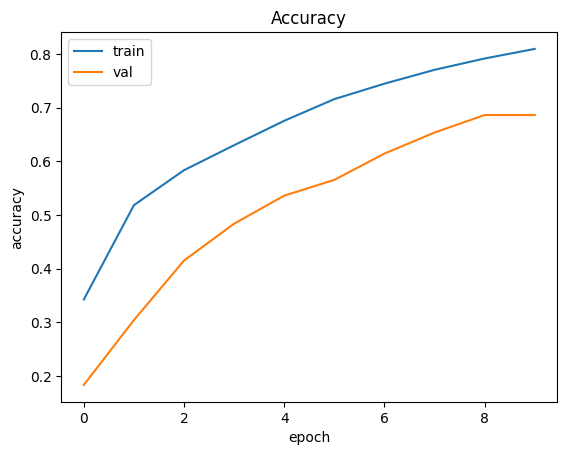

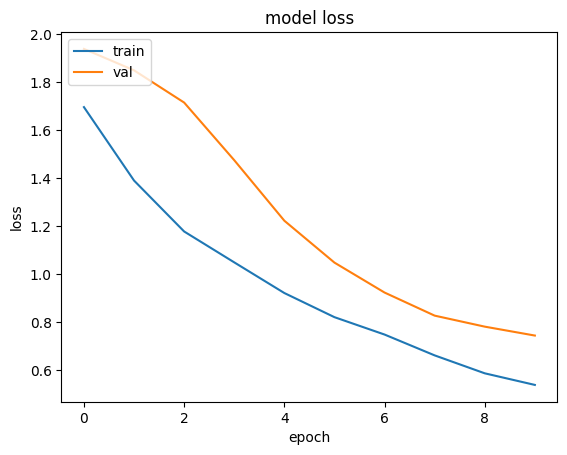

In [24]:
#accuracy and loss plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [25]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 2s 102ms/step


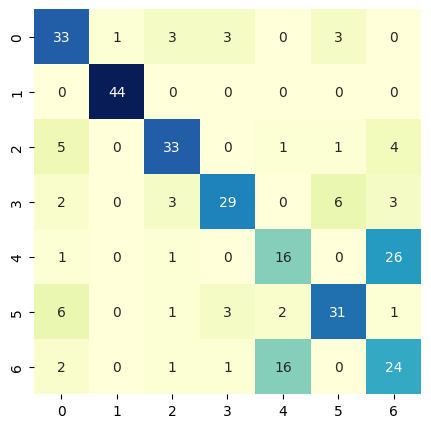

In [26]:
cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d");

In [27]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.67      0.77      0.72        43
           1       0.98      1.00      0.99        44
           2       0.79      0.75      0.77        44
           3       0.81      0.67      0.73        43
           4       0.46      0.36      0.41        44
           5       0.76      0.70      0.73        44
           6       0.41      0.55      0.47        44

    accuracy                           0.69       306
   macro avg       0.70      0.69      0.69       306
weighted avg       0.70      0.69      0.69       306



In [28]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(cls):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.939163,0.767442
1,1,0.996183,1.000000
2,2,0.965649,0.750000
3,3,0.973384,0.674419
4,4,0.927481,0.363636
5,5,0.961832,0.704545
6,6,0.870229,0.545455


#EfficientNetB2

In [ ]:
base_model = effnet.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(n_classes, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

31936256/31936256 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 32)   0           ['stem_bn[0][0]']            

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCHZ_SIZE, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
43/43 [==============================] - 35s 398ms/step - loss: 1.2564 - accuracy: 0.5320 - val_loss: 1.9434 - val_accuracy: 0.2059
Epoch 2/10
43/43 [==============================] - 11s 267ms/step - loss: 0.7640 - accuracy: 0.6988 - val_loss: 1.6455 - val_accuracy: 0.4444
Epoch 3/10
43/43 [==============================] - 12s 270ms/step - loss: 0.5761 - accuracy: 0.7575 - val_loss: 0.9068 - val_accuracy: 0.7026
Epoch 4/10
43/43 [==============================] - 12s 273ms/step - loss: 0.4705 - accuracy: 0.7844 - val_loss: 0.9333 - val_accuracy: 0.6895
Epoch 5/10
43/43 [==============================] - 12s 271ms/step - loss: 0.3982 - accuracy: 0.8157 - val_loss: 0.6121 - val_accuracy: 0.7549
Epoch 6/10
43/43 [==============================] - 12s 277ms/step - loss: 0.3841 - accuracy: 0.8270 - val_loss: 0.7369 - val_accuracy: 0.7222
Epoch 7/10
43/43 [==============================] - 12s 277ms/step - loss: 0.3568 - accuracy: 0.8347 - val_loss: 0.7375 - val_accuracy: 0.7320

In [ ]:
#model.save('/content/drive/MyDrive/smart_contract_classification/Models/EfficientnetB2.h5')

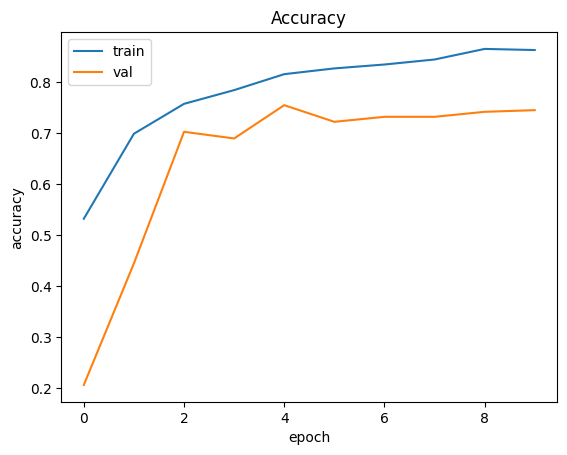

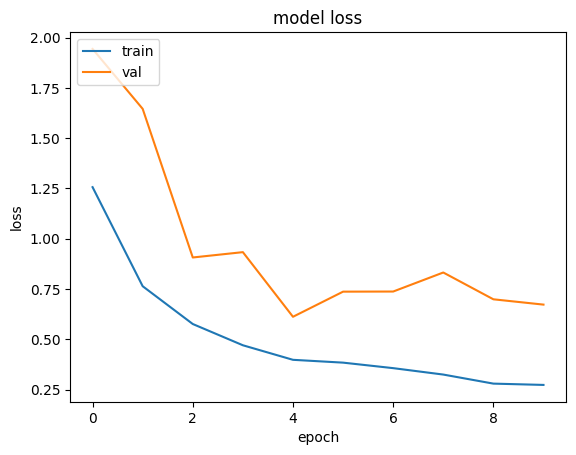

In [ ]:
#accuracy and loss plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 5s 96ms/step


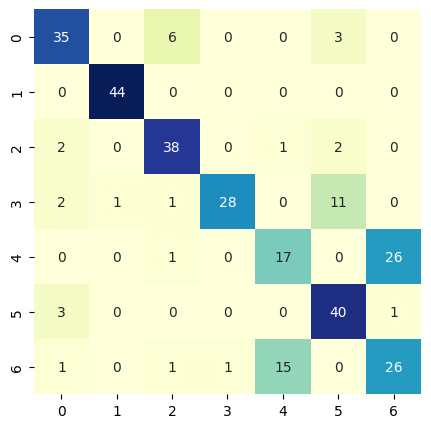

In [ ]:
cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='YlGnBu', fmt="d");

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80        44
           1       0.98      1.00      0.99        44
           2       0.81      0.88      0.84        43
           3       0.97      0.65      0.78        43
           4       0.52      0.39      0.44        44
           5       0.71      0.91      0.80        44
           6       0.49      0.59      0.54        44

    accuracy                           0.75       306
   macro avg       0.76      0.75      0.74       306
weighted avg       0.75      0.75      0.74       306



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(cls):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.969466,0.795455
1,1,0.996183,1.000000
2,2,0.965779,0.883721
3,3,0.996198,0.651163
4,4,0.938931,0.386364
5,5,0.938931,0.909091
6,6,0.896947,0.590909
